# Age

Problem: "Age" has an effect on "Survived" & has a lot of "NaN"

**Goal: replace "NaN" with actual values that are better than the "mean age"**

---
## import stuff

In [1]:
import pandas as pd
from sklearn import tree
from sklearn import model_selection
import graphviz

---
# define functions

In [2]:
# SETTINGS
jobs = -1
splits     = 5
repeats    = 5
param_grid = {"max_depth": [1, 2, 3, 4],
              "max_leaf_nodes": [2, 4, 6, 8, 12, 16, 24],
              "min_samples_leaf": [1, 4, 16],
              "min_samples_split": [2, 8, 32]}

### REGRESSION
def select_regression_tree(X, y):

    reg = model_selection.GridSearchCV(tree.DecisionTreeRegressor(random_state=1),
                                       param_grid,
                                       cv = model_selection.RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=2),
                                       n_jobs = jobs,
                                       verbose = 1)

    reg.fit(X,y)
    print_result(reg)
    
    return reg


### CLASSIFICATION
def select_classification_tree(X, y):

    clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(random_state=1),
                                       param_grid,
                                       cv = model_selection.RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=2),
                                       n_jobs = jobs,
                                       verbose=1)

    clf.fit(X,y)
    print_result(clf)
    
    return clf


### PRINT RESULT
def print_result(model):
    print(model.best_score_.round(4))
    for name, value in model.best_params_.items():
        print("{}: {}".format(name, value))

### PREPARE DATA
def prepare_1(data, cols):
    return pd.get_dummies(data, columns=cols)

def prepare_2(data, cols):
    return data.drop(cols, axis=1)

def prepare_3(data):
    #female_col = data.Sex.map({"female": 1, "male": 0})
    data["Female"] = (data.Sex == "female").astype(int)
    return data.drop(["Sex"], axis=1)

def prepare_4(data):
    data["Age_1"] = data.Age.fillna(data.Age.mean().round(0))
    return data

def prepare_5(data):
    return data.drop("Age", axis=1)

def prepare_6(data):
    return data.dropna(axis=0, subset=["Age"])

def process_name(dataset):
    
    # split string to separate last_name and rest (= title + first name(s))
    separated_names = dataset.Name.apply(lambda x: x.split(", ")).to_list()
    
    # get last names
    last_names = [i[0] for i in separated_names]
    
    # split the rest
    rest = [i[1].split(". ") for i in separated_names]
    
    # get titles
    titles = [i[0].split(" ")[-1] for i in rest]
    
    # get first name(s) without any brackets
    first_names = [i[1].replace("(","").replace(")", "").split(" ") for i in rest]
    
    # get number of first names
    number_first_names = [len(i) for i in first_names]
    
    # add columns to dataset
    dataset["Title"] = titles
    dataset["LastName"] = last_names
    dataset["FirstNames"] = first_names
    dataset["NumberFirstNames"] = number_first_names
    
    return dataset    

---
## import data

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_data.Age.head(25)

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      NaN
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     NaN
18    31.0
19     NaN
20    35.0
21    34.0
22    15.0
23    28.0
24     8.0
Name: Age, dtype: float64

In [5]:
train_data.Age.shape

(891,)

In [6]:
train_data.Age.isnull().sum()

177

---
# list all columns

In [7]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

---
## Option A: do not use "Age"

In [8]:
y_train = train_data.Survived
X_train = train_data[["Pclass", "Sex"]]

In [9]:
X_train

,Pclass,Sex
0,3,male
1,1,female
2,3,female
3,1,female
4,3,male
...,...,...
886,2,male
887,1,female
888,3,female
889,1,male


In [10]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

### one-hot encoding

In [11]:
X_train_1 = prepare_1(X_train.copy(), ["Pclass", "Sex"])
X_train_1

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0,1,0,1
1,1,0,0,1,0
2,0,0,1,1,0
3,1,0,0,1,0
4,0,0,1,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,1,0
888,0,0,1,1,0
889,1,0,0,0,1


In [12]:
clf = select_classification_tree(X_train_1, y_train)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.7868
max_depth: 1
max_leaf_nodes: 2
min_samples_leaf: 1
min_samples_split: 2


### get rid of redundant features

In [13]:
X_train_2 = prepare_2(X_train_1.copy(), ["Pclass_2", "Sex_male"])
X_train_2

,Pclass_1,Pclass_3,Sex_female
0,0,1,0
1,1,0,1
2,0,1,1
3,1,0,1
4,0,1,0
...,...,...,...
886,0,0,0
887,1,0,1
888,0,1,1
889,1,0,0


In [14]:
clf = select_classification_tree(X_train_1, y_train)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.7868
max_depth: 1
max_leaf_nodes: 2
min_samples_leaf: 1
min_samples_split: 2


### without one-hot encoding

In [15]:
X_train

,Pclass,Sex
0,3,male
1,1,female
2,3,female
3,1,female
4,3,male
...,...,...
886,2,male
887,1,female
888,3,female
889,1,male


In [16]:
X_train_3 = prepare_3(X_train.copy())
X_train_3

,Pclass,Female
0,3,0
1,1,1
2,3,1
3,1,1
4,3,0
...,...,...
886,2,0
887,1,1
888,3,1
889,1,0


In [17]:
clf = select_classification_tree(X_train_3, y_train)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.7868
max_depth: 1
max_leaf_nodes: 2
min_samples_leaf: 1
min_samples_split: 2


---
## B: Use "Age" with mean values

In [18]:
train_data.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [19]:
train_data.Age.mean().round(0)

30.0

In [20]:
X_train = train_data[["Pclass", "Sex", "Age"]]
X_train_3 = prepare_3(X_train.copy())
X_train_4 = prepare_4(X_train_3.copy())
X_train_4.head(20)

,Pclass,Age,Female,Age_1
0,3,22.0,0,22.0
1,1,38.0,1,38.0
2,3,26.0,1,26.0
3,1,35.0,1,35.0
4,3,35.0,0,35.0
5,3,NaN,0,30.0
6,1,54.0,0,54.0
7,3,2.0,0,2.0
8,3,27.0,1,27.0
9,2,14.0,1,14.0


In [21]:
X_train_5 = prepare_5(X_train_4.copy())
X_train_5

,Pclass,Female,Age_1
0,3,0,22.0
1,1,1,38.0
2,3,1,26.0
3,1,1,35.0
4,3,0,35.0
...,...,...,...
886,2,0,27.0
887,1,1,19.0
888,3,1,30.0
889,1,0,26.0


In [22]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [23]:
clf = select_classification_tree(X_train_5, y_train)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.798
max_depth: 4
max_leaf_nodes: 8
min_samples_leaf: 1
min_samples_split: 2


---
## improve prediction further by using a *better* "Age"

idea: using "Name", number of siblings & parents to approximate "Age"

occuring titles:
- [Mr](https://en.wikipedia.org/wiki/Mr.)
- Mrs
- Ms
- Master
- [Mlle](https://en.wikipedia.org/wiki/Mademoiselle_(title))
- Capt
- ...

In [24]:
train_data_2 = process_name(train_data.copy())
train_data_2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FirstNames,NumberFirstNames
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,"[Owen, Harris]",2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,"[John, Bradley, Florence, Briggs, Thayer]",5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,[Laina],1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,"[Jacques, Heath, Lily, May, Peel]",5
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,"[William, Henry]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,Montvila,[Juozas],1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Graham,"[Margaret, Edith]",2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,Johnston,"[Catherine, Helen, ""Carrie""]",3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,Behr,"[Karl, Howell]",2


In [25]:
sub_train_data_2 = train_data_2[["Age", "SibSp", "Parch", "Fare", "Title", "NumberFirstNames"]]
sub_train_data_2

,Age,SibSp,Parch,Fare,Title,NumberFirstNames
0,22.0,1,0,7.2500,Mr,2
1,38.0,1,0,71.2833,Mrs,5
2,26.0,0,0,7.9250,Miss,1
3,35.0,1,0,53.1000,Mrs,5
4,35.0,0,0,8.0500,Mr,2
...,...,...,...,...,...,...
886,27.0,0,0,13.0000,Rev,1
887,19.0,0,0,30.0000,Miss,2
888,NaN,1,2,23.4500,Miss,3
889,26.0,0,0,30.0000,Mr,2


In [26]:
sub_train_data_2.Title.isnull().sum()

0

In [27]:
sub_train_data_2.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [28]:
sub_train_data_2 = prepare_6(sub_train_data_2.copy())
sub_train_data_2

,Age,SibSp,Parch,Fare,Title,NumberFirstNames
0,22.0,1,0,7.2500,Mr,2
1,38.0,1,0,71.2833,Mrs,5
2,26.0,0,0,7.9250,Miss,1
3,35.0,1,0,53.1000,Mrs,5
4,35.0,0,0,8.0500,Mr,2
...,...,...,...,...,...,...
885,39.0,0,5,29.1250,Mrs,3
886,27.0,0,0,13.0000,Rev,1
887,19.0,0,0,30.0000,Miss,2
889,26.0,0,0,30.0000,Mr,2


In [29]:
sub_train_data_3 = prepare_1(sub_train_data_2.copy(), ["Title"])
sub_train_data_3

,Age,SibSp,Parch,Fare,NumberFirstNames,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,1,0,7.2500,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,1,0,71.2833,5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,0,0,7.9250,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,1,0,53.1000,5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,0,0,8.0500,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,39.0,0,5,29.1250,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
886,27.0,0,0,13.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
887,19.0,0,0,30.0000,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
889,26.0,0,0,30.0000,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
X_age = sub_train_data_3.drop(["Age"], axis=1)
y_age = sub_train_data_3.Age

In [31]:
reg_age = select_regression_tree(X_age, y_age)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.383
max_depth: 4
max_leaf_nodes: 12
min_samples_leaf: 16
min_samples_split: 2


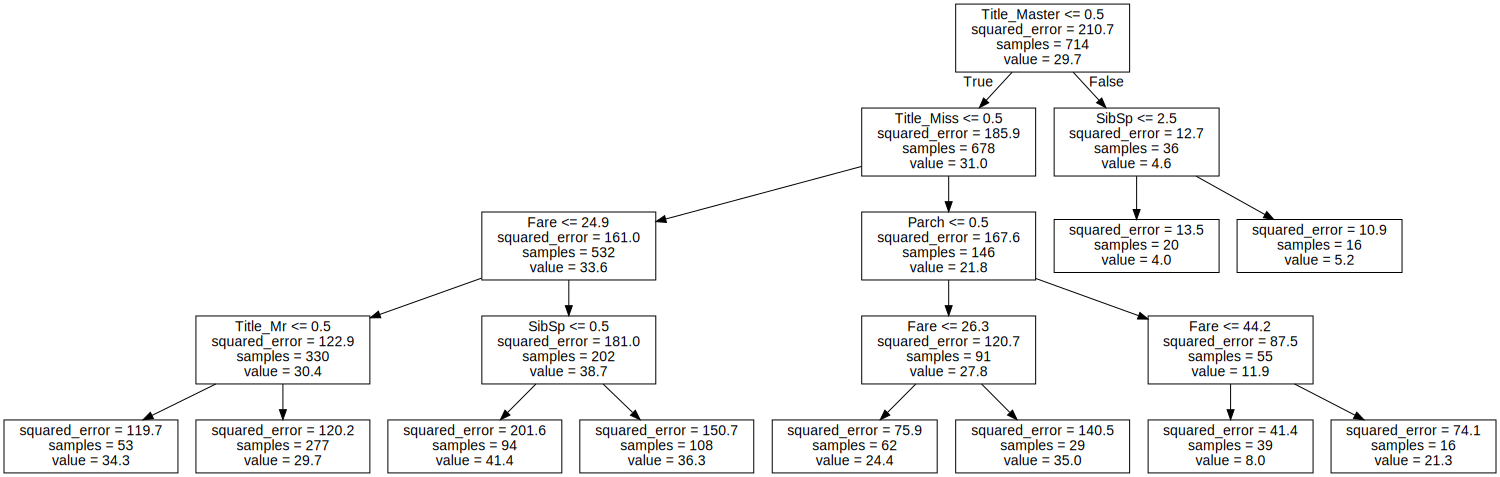

In [32]:
dot_data = tree.export_graphviz(reg_age.best_estimator_, out_file=None, 
                                feature_names=X_age.columns,
                                filled=False,
                                precision=1)
    
tree_plot = graphviz.Source(dot_data, format="svg")
tree_plot

In [33]:
sub_train_data_2 = train_data_2[["Age", "SibSp", "Parch", "Fare", "Title", "NumberFirstNames"]]
sub_train_data_3 = prepare_1(sub_train_data_2.copy(), ["Title"])
X = sub_train_data_3.drop(["Age"], axis=1)

In [34]:
predicted_age = reg_age.predict(X).round(0)

In [35]:
sub_train_data_3["Age_pred"] = predicted_age

In [36]:
sub_train_data_3.head(20)

,Age,SibSp,Parch,Fare,NumberFirstNames,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age_pred
0,22.0,1,0,7.2500,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,30.0
1,38.0,1,0,71.2833,5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,36.0
2,26.0,0,0,7.9250,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,24.0
3,35.0,1,0,53.1000,5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,36.0
4,35.0,0,0,8.0500,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,30.0
5,NaN,0,0,8.4583,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,30.0
6,54.0,0,0,51.8625,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,41.0
7,2.0,3,1,21.0750,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.0
8,27.0,0,2,11.1333,5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,34.0
9,14.0,1,0,30.0708,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,36.0


In [37]:
new_train_data = train_data.copy()
new_train_data.Age.fillna(sub_train_data_3.Age_pred, inplace=True)
new_train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,8.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [38]:
X_train = new_train_data[["Pclass", "Sex", "Age"]]
y_train = new_train_data.Survived

X_train_3 = prepare_3(X_train.copy())
X_train_3.head(20)

,Pclass,Age,Female
0,3,22.0,0
1,1,38.0,1
2,3,26.0,1
3,1,35.0,1
4,3,35.0,0
5,3,30.0,0
6,1,54.0,0
7,3,2.0,0
8,3,27.0,1
9,2,14.0,1


In [39]:
clf = select_classification_tree(X_train_3, y_train)

Fitting 25 folds for each of 252 candidates, totalling 6300 fits
0.7984
max_depth: 3
max_leaf_nodes: 8
min_samples_leaf: 4
min_samples_split: 2
